# Graph Matching

## Setup

In [2]:
#Colab
from google.colab import drive
drive.mount('/content/drive')
GNN_PATH = '/content/drive/MyDrive/Colab Notebooks/GNN/'

#HPC
#GNN_PATH = './Colab Notebooks/GNN/'
import os
if not os.path.exists(GNN_PATH):
    os.makedirs(GNN_PATH)

ModuleNotFoundError: No module named 'google'

In [3]:
# Install packages
!pip install torch-geometric torch scikit-learn pandas
!pip install git+https://github.com/Thinklab-SJTU/pygmtools.git

# Check pytorch version and make sure you use a GPU Kernel
!python3 -c "import torch; print(torch.__version__)"
!python3 -c "import torch; print(torch.version.cuda)"
!python3 --version
!nvidia-smi

  Cloning https://github.com/Thinklab-SJTU/pygmtools.git to /private/var/folders/zp/9w1jzgvj7bq6mh7s68n3f7dh0000gn/T/pip-req-build-09t3qsoq
  Running command git clone --filter=blob:none --quiet https://github.com/Thinklab-SJTU/pygmtools.git /private/var/folders/zp/9w1jzgvj7bq6mh7s68n3f7dh0000gn/T/pip-req-build-09t3qsoq
^C
2.2.2
None
Python 3.8.9
zsh:1: command not found: nvidia-smi


## Willow object Class dataset

In [4]:
# Set backend (required for pygmtools to work)
import pygmtools as pygm
pygm.set_backend('pytorch')  # or 'jittor', 'numpy' if you prefer

# Load the WillowObject dataset
from pygmtools.dataset import WillowObject

size = 1024  # Image size

# Load dataset
dataset = WillowObject(
    sets='train',           # Either 'train' or 'test'
    obj_resize=(size, size)   # Resize objects to a consistent image size
)

dataset.process()

/Users/matteogiorgi/Github/GNN_Notebooks/.venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/matteogiorgi/Github/GNN_Notebooks/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


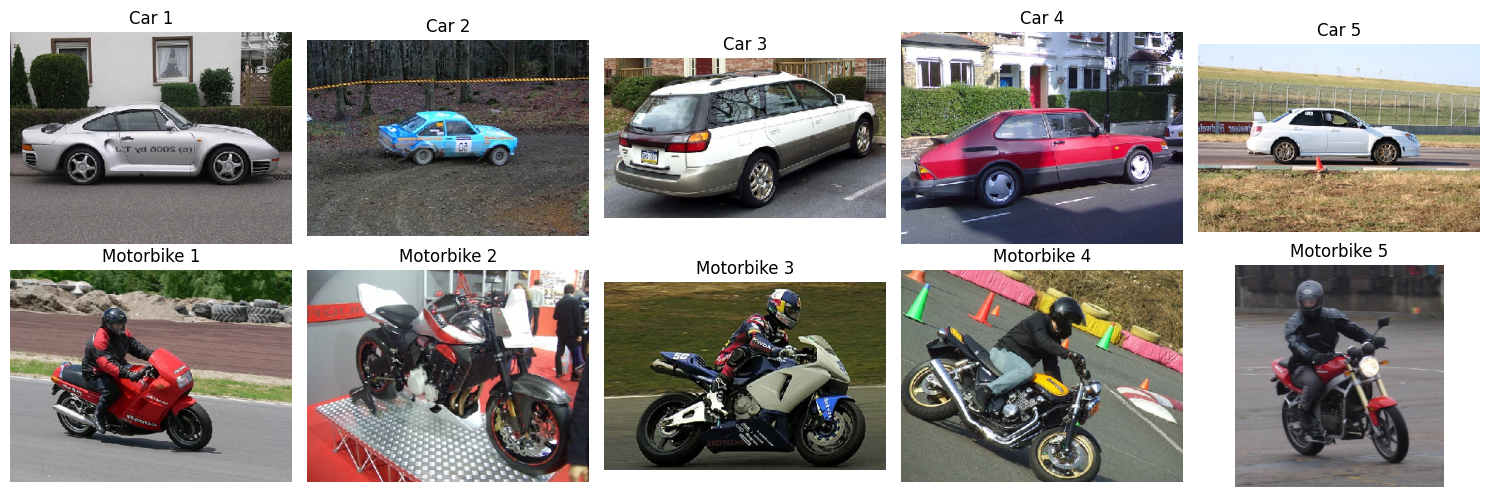

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Paths
categories = ["Car", "Motorbike"]
base_path = "data/WillowObject/WILLOW-ObjectClass"
dataset_path = os.path.join("data/WillowObject", f"data-({size}, {size})-willow-0.json")

# Number of images
n_images = 5

# Load and visualization
fig, axes = plt.subplots(len(categories), n_images, figsize=(15, 5))
for i, category in enumerate(categories):
    category_path = os.path.join(base_path, category)
    image_files = sorted([f for f in os.listdir(category_path) if f.endswith(".png")])[:n_images]
    for j, img_file in enumerate(image_files):
        img_path = os.path.join(category_path, img_file)
        image = Image.open(img_path)
        axes[i, j].imshow(image)
        axes[i, j].set_title(f"{category} {j+1}")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

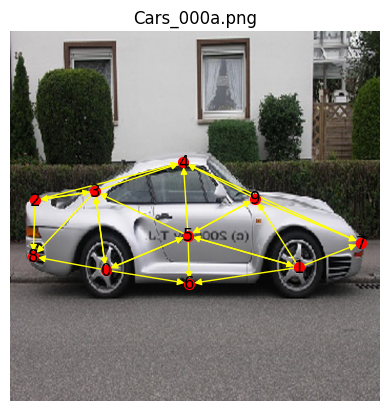

In [6]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import Delaunay
import networkx as nx

# Load the JSON file
with open(dataset_path, "r") as f:
    data = json.load(f)

def plot_graph_from_kpts(entry):
    kpts = entry["kpts"]
    points = [(kp["x"], kp["y"]) for kp in kpts]
    tri = Delaunay(points)

    # Create graph
    G = nx.DiGraph()
    for i, (x, y) in enumerate(points):
        G.add_node(i, pos=(x, y))

    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                G.add_edge(simplex[i], simplex[j])

    # Plot image
    img = mpimg.imread(entry["path"])
    img_resized = Image.open(entry["path"]).resize((size, size))
    plt.imshow(img_resized)
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, node_color='red', edge_color='yellow', node_size=50, with_labels=True)
    plt.axis('off')
    plt.title(entry["path"].split('/')[-1])
    plt.show()

# Separate the two lists
car_entries = {k: v for k, v in data.items() if v["cls"] == "Car"}
motorbike_entries = {k: v for k, v in data.items() if v["cls"] == "Motorbike"}

# Show graph for the first image only
for i, (key, entry) in enumerate(car_entries.items()):
    plot_graph_from_kpts(entry)
    break


In [7]:
def graph_from_kpts(entry):
    kpts = entry["kpts"]
    points = [(kp["x"], kp["y"]) for kp in kpts]
    tri = Delaunay(points)

    # Create graph
    G = nx.DiGraph()
    # Add name of the image
    G.graph['name'] = entry["path"].split('/')[-1].replace('.png', '')
    for i, (x, y) in enumerate(points):
        G.add_node(i, pos=(x, y))

    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                G.add_edge(simplex[i], simplex[j])
    return G

def get_graphs(entries):
    graphs = []
    for entry in entries:
        G = graph_from_kpts(entry)
        graphs.append(G)
    return graphs

In [8]:
# Get graphs for car and motorbike entries
car_graphs = get_graphs(car_entries.values())
motorbike_graphs = get_graphs(motorbike_entries.values())

#make dir if not os.path.exists(base_path / graphs):
graphs_path = os.path.join(base_path, "Graphs")
car_path = os.path.join(graphs_path, "car")
motorbike_path = os.path.join(graphs_path, "motorbike")

if not os.path.exists(graphs_path):
    os.makedirs(car_path)
    os.makedirs(motorbike_path)

# Save graphs to disk
import pickle
with open(car_path + "car_graphs.pkl", "wb") as f:
    pickle.dump(car_graphs, f)
with open(motorbike_path + "motorbike_graphs.pkl", "wb") as f:
    pickle.dump(motorbike_graphs, f)
# Load graphs from disk
with open(car_path + "car_graphs.pkl", "rb") as f:
    car_graphs = pickle.load(f)
with open(motorbike_path + "motorbike_graphs.pkl", "rb") as f:
    motorbike_graphs = pickle.load(f)

# Check the number of graphs
print(f"Number of car graphs: {len(car_graphs)}")
print(f"Number of motorbike graphs: {len(motorbike_graphs)}")
# Check the first graph
print(car_graphs[0])
print(car_graphs[0].nodes(data=True))
print(car_graphs[0].edges(data=True))


Number of car graphs: 40
Number of motorbike graphs: 40
DiGraph named 'Cars_000a' with 10 nodes and 25 edges
[(0, {'pos': (264.98395721925135, 660.7629233511587)}), (1, {'pos': (799.5721925133689, 653.2335115864529)}), (2, {'pos': (69.21925133689844, 467.50802139037444)}), (3, {'pos': (234.86631016042784, 442.4099821746882)}), (4, {'pos': (479.57219251336886, 362.09625668449206)}), (5, {'pos': (492.7486631016043, 565.3903743315509)}), (6, {'pos': (496.5133689839571, 698.409982174688)}), (7, {'pos': (972.748663101604, 585.4688057041)}), (8, {'pos': (63.57219251336904, 623.1158645276292)}), (9, {'pos': (679.1016042780747, 462.48841354723714)})]
[(0, 5, {}), (0, 6, {}), (0, 3, {}), (0, 8, {}), (1, 9, {}), (1, 7, {}), (1, 6, {}), (1, 5, {}), (2, 4, {}), (2, 3, {}), (2, 8, {}), (3, 2, {}), (3, 4, {}), (3, 8, {}), (3, 0, {}), (4, 7, {}), (5, 4, {}), (5, 3, {}), (5, 1, {}), (5, 6, {}), (5, 9, {}), (5, 0, {}), (9, 4, {}), (9, 7, {}), (9, 5, {})]


## Graph Matching with pygmtools

### Spectral Matching

Matching accuracy: 0.40
Predicted matching: [(0, 4), (1, 5), (2, 6), (3, 0), (4, 3), (5, 1), (6, 2), (7, 8), (8, 7), (9, 9)]
Ground truth permutation: [5 4 7 3 0 1 2 8 6 9]


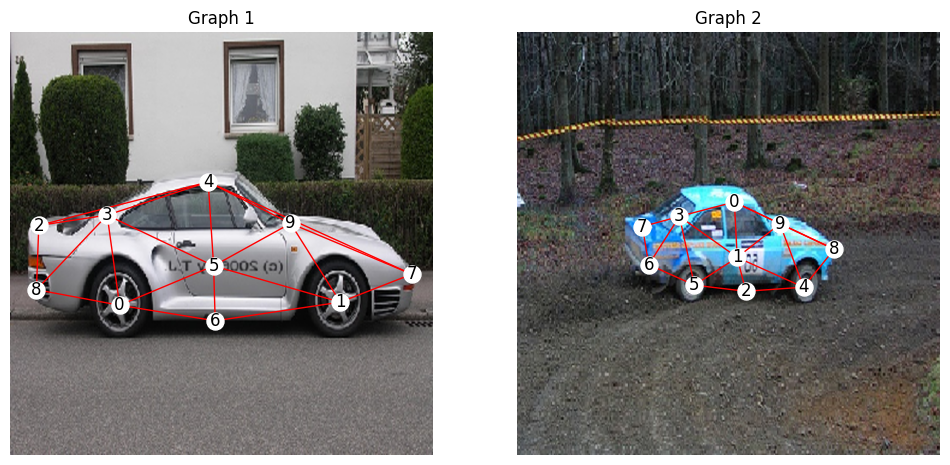

In [9]:
import torch
import pygmtools as pygm
import functools
import numpy as np
from scipy.optimize import linear_sum_assignment

pygm.set_backend('pytorch')

# Nodes with positions
nodes1 = car_graphs[0].nodes(data=True)  # example of a car graph
edges1 = car_graphs[0].edges(data=True)  # example of a car graph

nodes2 = car_graphs[1].nodes(data=True)  # example of a car graph
edges2 = car_graphs[1].edges(data=True)  # example of a car graph

# === STEP 1: Base graph construction (e.g., "cars") ===
n = 10  # number of nodes

# Use the nodes and edges provided for graph 1
nodes1 = [(i, {'pos': data['pos']}) for i, data in nodes1]
edges1 = [(i, j, {}) for i, j, _ in edges1]

# === STEP 2: Apply permutation to graph 2 ===
perm = np.random.permutation(n)  # random permutation of nodes
# Node i of G2 corresponds to node perm[i] of G1
nodes2 = [(i, {'pos': data['pos']}) for i, data in nodes2]
nodes2 = [(perm[i], data) for i, data in nodes2]
nodes2 = sorted(nodes2, key=lambda x: x[0])  # sort by node ID

# Edges also need to be remapped
edges2 = [(perm[i], perm[j], {}) for (i, j, data) in edges2]

# === STEP 3: Ground truth: permutation matrix ===
X_gt = torch.zeros(n, n)
for i in range(n):
    X_gt[i, perm[i]] = 1  # node i of G1 → node perm[i] of G2

# === STEP 4: Convert data for pygmtools ===
def edges_to_adj(edges, n):
    adj = torch.zeros((n, n))
    for i, j, _ in edges:
        adj[i, j] = 1
        adj[j, i] = 1
    return adj

A1 = edges_to_adj(edges1, n).unsqueeze(0)
A2 = edges_to_adj(edges2, n).unsqueeze(0)

# Convert to sparse and build affinity matrix
conn1, edge1, ne1 = pygm.utils.dense_to_sparse(A1)
conn2, edge2, ne2 = pygm.utils.dense_to_sparse(A2)

n_tensor = torch.tensor([n])

gaussian_aff = functools.partial(pygm.utils.gaussian_aff_fn, sigma=1.)

K = pygm.utils.build_aff_mat(
    None, edge1, conn1,
    None, edge2, conn2,
    n_tensor, None, n_tensor, None,
    edge_aff_fn=gaussian_aff
)

# === STEP 5: Solve matching with SM ===
S = pygm.sm(K, n1=n_tensor, n2=n_tensor)
S = S.view(n, n).detach().numpy()

# Final matching
row_ind, col_ind = linear_sum_assignment(-S)
X_pred = np.zeros_like(S)
X_pred[row_ind, col_ind] = 1

# === STEP 6: Accuracy ===
acc = (torch.tensor(X_pred) * X_gt).sum() / X_gt.sum()
print(f"Matching accuracy: {acc.item():.2f}")
print("Predicted matching:", list(zip(row_ind, col_ind)))
print("Ground truth permutation:", perm)

# === STEP 7: Visualization ===
# Visualize in a single image the two cars and the two graphs with connections between matched nodes
def plot_graphs(nodes1, edges1, nodes2, edges2, entry1, entry2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Graph 1 with image
    img1 = mpimg.imread(entry1["path"])
    img1_resized = Image.open(entry1["path"]).resize((size, size))
    axs[0].imshow(img1_resized)
    G1 = nx.Graph()
    G1.add_nodes_from(nodes1)
    G1.add_edges_from(edges1)
    pos1 = {i: data['pos'] for i, data in nodes1}
    nx.draw(G1, pos=pos1, ax=axs[0], node_color='white', edge_color='red', node_size=150, with_labels=True)
    axs[0].set_title("Graph 1")
    axs[0].axis('off')

    # Graph 2 with image
    img2 = mpimg.imread(entry2["path"])
    img2_resized = Image.open(entry2["path"]).resize((size, size))
    axs[1].imshow(img2_resized)
    G2 = nx.Graph()
    G2.add_nodes_from(nodes2)
    G2.add_edges_from(edges2)
    pos2 = {i: data['pos'] for i, data in nodes2}
    nx.draw(G2, pos=pos2, ax=axs[1], node_color='white', edge_color='red', node_size=150, with_labels=True)
    axs[1].set_title("Graph 2")
    axs[1].axis('off')

    plt.show()

# Example usage
plot_graphs(nodes1, edges1, nodes2, edges2, car_entries["Cars_000a"], car_entries["Cars_001b"])


### IPCA Model

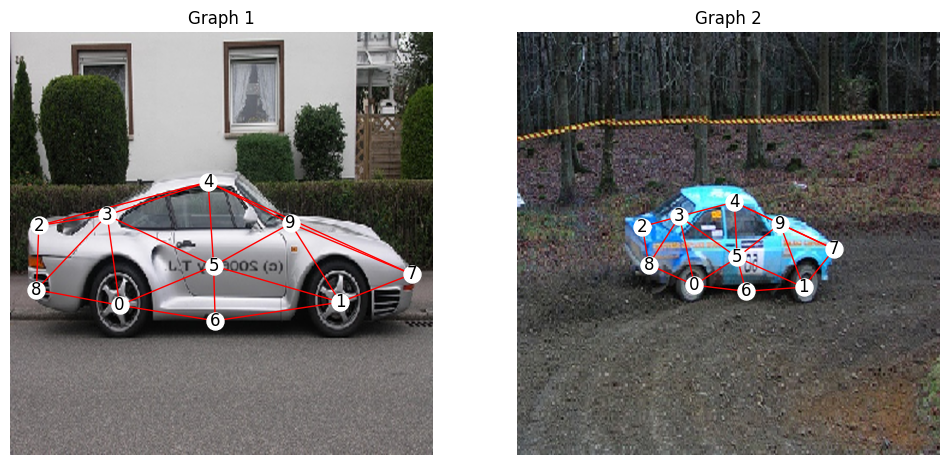

Graph 1 node features shape: torch.Size([10, 2])
Graph 2 node features shape: torch.Size([10, 2])
Graph 1 node features shape: torch.Size([10, 1024])
Graph 2 node features shape: torch.Size([10, 1024])
Graph Matching Matrix:
     0    1    2    3    4             5    6    7    8    9
0  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
6  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
8  1.0  1.0  1.0  1.0  1.0  6.580278e-19  1.0  1.0  1.0  1.0
9  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
Hungarian:
     0    1    2    3    4    5    6    7    8    9
0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0

In [10]:
import torch
import numpy as np
import pygmtools as pygm
import torch.nn.functional as F
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
import pygmtools as pygm
import torch

pygm.BACKEND = 'pytorch'

# Load graph data
graph1 = car_graphs[0]
graph2 = car_graphs[1]

nodes1 = graph1.nodes(data=True)
nodes2 = graph2.nodes(data=True)
edges1 = graph1.edges(data=True)
edges2 = graph2.edges(data=True)

plot_graphs(nodes1, edges1, nodes2, edges2, car_entries[graph1.graph['name']], car_entries[graph2.graph['name']])

adj1 = nx.adjacency_matrix(graph1).todense()
adj2 = nx.adjacency_matrix(graph2).todense()

# Extract node features (e.g., positions) from the graph nodes
g1_node_feat = torch.tensor([data['pos'] for _, data in graph1.nodes(data=True)], dtype=torch.float32)
g2_node_feat = torch.tensor([data['pos'] for _, data in graph2.nodes(data=True)], dtype=torch.float32)
adj1 = torch.tensor(adj1, dtype=torch.float32)
adj2 = torch.tensor(adj2, dtype=torch.float32)

print(f"Graph 1 node features shape: {g1_node_feat.shape}")
print(f"Graph 2 node features shape: {g2_node_feat.shape}")

desired_dim = 1024

# Padding with 0s
g1_node_feat_padded = F.pad(g1_node_feat, (0, desired_dim - g1_node_feat.shape[1]))
g2_node_feat_padded = F.pad(g2_node_feat, (0, desired_dim - g2_node_feat.shape[1]))

print(f"Graph 1 node features shape: {g1_node_feat_padded.shape}")
print(f"Graph 2 node features shape: {g2_node_feat_padded.shape}")

# Apply IPCA-GM model for graph matching
match_result = pygm.ipca_gm(
    A1=adj1.to(torch.float32), A2=adj2.to(torch.float32),
    feat1=g1_node_feat_padded, feat2=g2_node_feat_padded,
    pretrain='willow'
)

# Convert to a DataFrame for better readability
df_match = pd.DataFrame(match_result.detach().numpy())

matched = pygm.hungarian(match_result)
df_matched = pd.DataFrame(matched)

# Display the DataFrame in the terminal
# Calculate accuracy
identity_matrix = torch.eye(n)  # Ground truth is the identity matrix
accuracy = (matched * identity_matrix).sum() / identity_matrix.sum()

print("Graph Matching Matrix:")
print(df_match.to_string(index=True, header=True))
print("Hungarian:")
print(df_matched.to_string(index=True, header=True))
print(f"Matching Accuracy: {accuracy.item():.2f}")


The model expects an input of dimensions [10, 1024], which corresponds to features extracted from CNN layers applied to the image. Since we do not have access to these features, the results obtained are suboptimal.

## Graph Matching with GNN from scratch 

In [11]:
# Set Seed for reproducibility
import random
import numpy as np
import torch

seed = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed once at the beginning
set_seed(seed)

# For reproducible DataLoader shuffle
g = torch.Generator()
g.manual_seed(seed)

### Dataset split

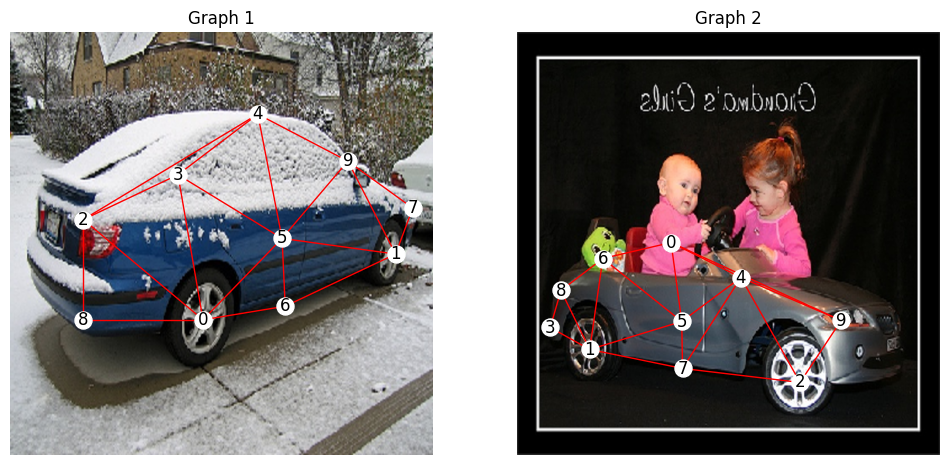

G1 nodes: [(0, {'pos': (467.02911283376415, 696.0289405684754)}), (1, {'pos': (933.5180017226531, 536.7400516795864)}), (2, {'pos': (176.89577950043073, 453.3030146425494)}), (3, {'pos': (406.34763135228263, 344.5820269882284)}), (4, {'pos': (599.769853574505, 197.93511340798145)}), (5, {'pos': (658.5550387596901, 498.8141257536605)}), (6, {'pos': (666.1402239448754, 663.1598047660062)}), (7, {'pos': (975.2365202411717, 425.490668963537)}), (8, {'pos': (176.89577950043073, 696.0289405684754)}), (9, {'pos': (817.8439276485791, 311.7128911857593)})]
G2 permuted nodes: [(0, {'pos': (372.02681365263913, 508.8100053382138)}), (1, {'pos': (174.9592590502349, 767.8360100663463)}), (2, {'pos': (684.5480871130177, 847.7225348890414)}), (3, {'pos': (79.41135378846313, 714.578326851216)}), (4, {'pos': (541.22622922036, 593.5381377259206)}), (5, {'pos': (397.90437132770245, 700.0535041561807)}), (6, {'pos': (206.80856080415887, 547.5428658583083)}), (7, {'pos': (399.8949526873227, 813.831281933958

In [18]:
import torch
from torch_geometric.data import Data
from typing import List, Tuple

# Split the data into 60% train, 20% validation, and 20% test
def split_graphs(graphs):
    train, temp = train_test_split(graphs, test_size=0.4, random_state=seed)
    val, test = train_test_split(temp, test_size=0.5, random_state=seed)
    return train, val, test

cars_train, cars_val, cars_test = split_graphs(car_graphs)

def generate_matching_pairs_from_digraph_nx(
    g1: nx.DiGraph,
    graph_list: List[nx.DiGraph],
    g1_idx: int,
    pairs_list: List[Tuple[nx.DiGraph, nx.DiGraph, torch.Tensor]]
) -> None:
    """
    Generate all pairs (g1, g2_permuted, P) between a DiGraph g1 and every other graph in graph_list,
    permuting nodes and edges of g2. P is the full permutation matrix (N x N) such that
    P[i, j] = 1 iff node i in g1 corresponds to node j in g2_permuted.

    Nodes must be consecutively indexed and have an attribute 'pos'.

    Args:
        g1: Reference graph.
        graph_list: List of graphs to compare with g1.
        g1_idx: Index of g1 in the list.
        pairs_list: List to which the generated pairs are added.
    """

    assert len(g1.nodes) == 10, f"Graph {g1_idx} has {len(g1.nodes)} nodes!"

    for j, g2_orig in enumerate(graph_list):
        if j == g1_idx:
            continue  # skip itself

        assert g1.number_of_nodes() == g2_orig.number_of_nodes(), \
            f"Graph {g1_idx} and {j} have a different number of nodes"

        num_nodes = g1.number_of_nodes()

        # Ensure nodes are indexed from 0 to N-1
        nodes_g2 = list(sorted(g2_orig.nodes()))
        assert nodes_g2 == list(range(num_nodes)), "Nodes must be consecutively indexed"

        # Random permutation
        perm = torch.randperm(num_nodes)

        # Create permutation matrix P
        P = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
        for i in range(num_nodes):
            P[i, perm[i]] = 1.0  # node i in G1 corresponds to perm[i] in G2_permuted

        # Construct permuted G2
        g2_permuted = nx.DiGraph()
        g2_permuted.graph['name'] = f"{g2_orig.graph['name']}"

        # Add permuted nodes with corresponding attributes
        for new_idx in range(num_nodes):
            old_idx = perm[new_idx].item()
            pos = g2_orig.nodes[old_idx]['pos']
            g2_permuted.add_node(new_idx, pos=pos)

        # Add edges, respecting the node permutation
        for u, v, data in g2_orig.edges(data=True):
            new_u = (perm == u).nonzero(as_tuple=True)[0].item()
            new_v = (perm == v).nonzero(as_tuple=True)[0].item()
            g2_permuted.add_edge(new_u, new_v, **data)

        pairs_list.append((g1, g2_permuted, P.T))


train_list = []
for i, g1 in enumerate(cars_train):
    generate_matching_pairs_from_digraph_nx(g1, cars_train, i, train_list)

val_list = []
for i, g1 in enumerate(cars_val):
    generate_matching_pairs_from_digraph_nx(g1, cars_val, i, val_list)

test_list = []
for i, g1 in enumerate(cars_test):
    generate_matching_pairs_from_digraph_nx(g1, cars_test, i, test_list)


# Visualize the two graphs
g1_out, g2_perm, gt_perm = train_list[0]

plot_graphs(
    nodes1=g1_out.nodes(data=True),
    edges1=g1_out.edges(data=True),
    nodes2=g2_perm.nodes(data=True),
    edges2=g2_perm.edges(data=True),
    entry1=data[g1_out.graph["name"]],
    entry2=data[g2_perm.graph["name"]]
)

print("G1 nodes:", g1_out.nodes(data=True))
print("G2 permuted nodes:", g2_perm.nodes(data=True))
print("Ground truth permutation:\n", gt_perm)

In [ ]:
from torch.utils.data import Dataset

class GraphMatchingDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        g1, g2, perm_matrix = self.pairs[idx]

        # Estrai le feature nodali (assunte come 'pos')
        x1 = torch.stack([torch.tensor(g1.nodes[n]['pos'], dtype=torch.float32) for n in g1.nodes()])
        x2 = torch.stack([torch.tensor(g2.nodes[n]['pos'], dtype=torch.float32) for n in g2.nodes()])

        # Costruisci edge_index per PyTorch Geometric
        def nx_to_edge_index(graph):
            edges = list(graph.edges())
            if not edges:
                return torch.empty((2, 0), dtype=torch.long)
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            return edge_index

        edge_index1 = nx_to_edge_index(g1)
        edge_index2 = nx_to_edge_index(g2)

        return x1, edge_index1, x2, edge_index2, perm_matrix

In [24]:
from torch.utils.data import DataLoader
# Define hyperparameters
in_dim = 2  # Dimension of node features
hidden_dim = 64  # Hidden dimension for GNN
out_dim = 32  # Output dimension for GNN
num_epochs = 20
learning_rate = 0.001
batch_size = 5

train_dataset = GraphMatchingDataset(train_list)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

val_dataset = GraphMatchingDataset(val_list)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = GraphMatchingDataset(test_list)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [15]:
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
import torch

class MatchingModel(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        
        # Define a list of GCN layers (2-layer GCN in this case)
        self.gnn = nn.ModuleList([
            GCNConv(in_dim, hidden_dim),      # First GCN layer: input → hidden
            GCNConv(hidden_dim, out_dim)      # Second GCN layer: hidden → output
        ])

    def encode(self, x, edge_index):
        """
        Apply GCN layers to node features using the graph structure.
        
        Args:
            x (Tensor): Node features matrix of shape [num_nodes, in_dim]
            edge_index (LongTensor): Edge list in COO format [2, num_edges]
        
        Returns:
            x (Tensor): Node embeddings of shape [num_nodes, out_dim]
        """
        x = F.relu(self.gnn[0](x, edge_index))  # ReLU sul primo layer
        x = self.gnn[1](x, edge_index)          
        return x

    def forward(self, x1, edge_index1, x2, edge_index2):
        """
        Encode two graphs independently, then compute pairwise similarity.

        Args:
            x1 (Tensor): Node features of graph 1 [N, in_dim]
            edge_index1 (LongTensor): Edges of graph 1 [2, num_edges]
            x2 (Tensor): Node features of graph 2 [N, in_dim]
            edge_index2 (LongTensor): Edges of graph 2 [2, num_edges]

        Returns:
            scores (Tensor): Matching score matrix [N, N], where
                             scores[i, j] = similarity between node i in G1 and node j in G2
        """
        # Compute node embeddings for both graphs
        h1 = self.encode(x1, edge_index1)  # [N, D]
        h2 = self.encode(x2, edge_index2)  # [N, D]

        # Compute pairwise similarity between node embeddings (dot product)
        scores = torch.matmul(h1, h2.T)     # [N, N]

        return scores  # Return similarity matrix (can be used with BCE or softmax loss)

### Training

In [ ]:
import torch.nn.functional as F

def train_epoch(model, loader, optimizer):
    """
    Train the model for one epoch.

    Args:
        model: The graph matching model to be trained.
        loader: DataLoader providing batches of training data.
        optimizer: Optimizer used for updating model parameters.

    Returns:
        Average loss over all batches in the epoch.
    """
    model.train()  # Set the model to training mode
    total_loss = 0  # Initialize total loss

    for x1, edge1, x2, edge2, P in loader:  # Iterate over batches
        optimizer.zero_grad()  # Reset gradients

        # Remove extra dimensions (if any) from the batch
        x1, edge1 = x1.squeeze(0), edge1.squeeze(0)
        x2, edge2 = x2.squeeze(0), edge2.squeeze(0)
        P = P.squeeze(0)

        # Forward pass: compute matching scores
        scores = model(x1, edge1, x2, edge2)  # Output shape: [N, N]

        # Compute binary cross-entropy loss
        loss = F.binary_cross_entropy_with_logits(scores, P)
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update model parameters
        total_loss += loss.item()  # Accumulate loss

    # Return average loss over all batches
    return total_loss / len(loader)

def evaluate(model, loader):
    """
    Evaluate the model on validation or test data.

    Args:
        model: The graph matching model to be evaluated.
        loader: DataLoader providing batches of validation/test data.

    Returns:
        Accuracy of the model on the provided data.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total predictions counter

    with torch.no_grad():  # Disable gradient computation
        for x1, edge1, x2, edge2, P in loader:  # Iterate over batches
            # Remove extra dimensions (if any) from the batch
            x1, edge1 = x1.squeeze(0), edge1.squeeze(0)
            x2, edge2 = x2.squeeze(0), edge2.squeeze(0)
            P = P.squeeze(0)

            # Forward pass: compute matching scores
            scores = model(x1, edge1, x2, edge2)  # Output shape: [N, N]

            # Predict the best matching for each node
            pred = torch.argmax(scores, dim=1)  # Predicted permutation
            target = torch.argmax(P, dim=1)  # Ground truth permutation

            # Count correct predictions
            correct += (pred == target).sum().item()
            total += target.size(0)  # Update total predictions count

    # Return accuracy as the ratio of correct predictions to total predictions
    return correct / total

In [17]:
model = MatchingModel(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    loss = train_epoch(model, train_loader, optimizer)
    acc = evaluate(model, val_loader)
    print(f"[Epoch {epoch}] Loss: {loss:.4f} | Val Acc: {acc:.4f}")

RuntimeError: stack expects each tensor to be equal size, but got [2, 24] at entry 0 and [2, 23] at entry 1